In [1]:
import torch
import numpy as np
from sklearn.datasets import make_regression
import random
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torch.utils.data import random_split
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3.1 Автоматическое дифференцирование в `torch`

3.1.1 Воспользовавшись классами `Neuron` и `SquaredLoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [3]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [4]:
class SquaredLoss:
  def forward(self, y_pred, y_true):
    self.y_pred = torch.tensor(y_pred, requires_grad=True)
    self.z = (self.y_pred - y_true) ** 2
    return self.z

  def backward(self):
    self.z.backward()
    self.dinput =  self.y_pred.grad

In [5]:
class Neuron:
  def __init__(self, n_inputs):
    self.n_inputs = n_inputs
    self.weights = torch.randn(n_inputs)
    self.bias = torch.randn(1)
  
  def forward(self, input):
    self.input = input
    return torch.dot(self.weights, input) + self.bias
  
  def backward(self, dvalue):
    # dvalue - значение производной, которое приходит нейрону от следующего слоя сети
    # в данном случае это будет значение df/dc (созданное методом backwards у объекта MSELoss) - по сути производная ошибки dE
    self.dweights = dvalue * self.input # df/dW
    self.dinput =  dvalue * self.weights # df/wX
    self.dbias = dvalue # df/db

In [6]:
n_inputs = 4 # <размерность элемента выборки >
lr = 0.01 #  скорость обучения
n_epoch = 100 #  количество эпох

neuron = Neuron(n_inputs)
loss = SquaredLoss()

losses = []
for epoch in range(100):
  for x_example, y_example in random.sample(list(zip(X, y)), 20):
    # forward pass
    y_pred = neuron.forward(x_example) # <прогон через нейрон>
    curr_loss = loss.forward(y_pred, y_example) # <прогон через функцию потерь>
    losses.append(curr_loss)

    # backprop
    loss.backward()
    neuron.backward(loss.dinput)
    # градиентный спуск
    neuron.weights -= lr * neuron.dweights
    neuron.bias -= lr * neuron.dbias
  print(f'epoch {epoch} mean loss {sum(losses) / len(losses)}')
    # <вызов методов backward>
    # обратите внимание на последовательность вызовов: от конца к началу

    # <шаг оптимизации для весов (weights и bias) нейрона>

epoch 0 mean loss tensor([15136.0029], grad_fn=<DivBackward0>)
epoch 1 mean loss tensor([9268.2432], grad_fn=<DivBackward0>)
epoch 2 mean loss tensor([7495.3950], grad_fn=<DivBackward0>)
epoch 3 mean loss tensor([6178.3389], grad_fn=<DivBackward0>)
epoch 4 mean loss tensor([5048.8018], grad_fn=<DivBackward0>)
epoch 5 mean loss tensor([4257.2593], grad_fn=<DivBackward0>)

<ipython-input-4-c53ef009eda7>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_pred = torch.tensor(y_pred, requires_grad=True)



epoch 6 mean loss tensor([3683.3684], grad_fn=<DivBackward0>)
epoch 7 mean loss tensor([3232.4138], grad_fn=<DivBackward0>)
epoch 8 mean loss tensor([2878.0017], grad_fn=<DivBackward0>)
epoch 9 mean loss tensor([2595.8506], grad_fn=<DivBackward0>)
epoch 10 mean loss tensor([2362.1504], grad_fn=<DivBackward0>)
epoch 11 mean loss tensor([2166.2400], grad_fn=<DivBackward0>)
epoch 12 mean loss tensor([2000.0544], grad_fn=<DivBackward0>)
epoch 13 mean loss tensor([1857.3861], grad_fn=<DivBackward0>)
epoch 14 mean loss tensor([1733.6553], grad_fn=<DivBackward0>)
epoch 15 mean loss tensor([1625.3522], grad_fn=<DivBackward0>)
epoch 16 mean loss tensor([1529.7549], grad_fn=<DivBackward0>)
epoch 17 mean loss tensor([1444.7736], grad_fn=<DivBackward0>)
epoch 18 mean loss tensor([1368.7360], grad_fn=<DivBackward0>)
epoch 19 mean loss tensor([1300.3018], grad_fn=<DivBackward0>)
epoch 20 mean loss tensor([1238.3834], grad_fn=<DivBackward0>)
epoch 21 mean loss tensor([1182.0939], grad_fn=<DivBackwar

3.1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [7]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

## 3.2 Алгоритмы оптимизации в `torch.optim`

3.2.1 Решить задачу 3.1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

3.2.2 Решить задачу 3.1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

## 3.3 Построение сетей при помощи `torch.nn`

3.3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [8]:
X = torch.linspace(0, 1, 100).view(-1, 1)
# можно поэкспериментировать с коэф 0.1
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [9]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        # поэкспериментировать с другиями функциями активации
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sine_net = SineNet(50)

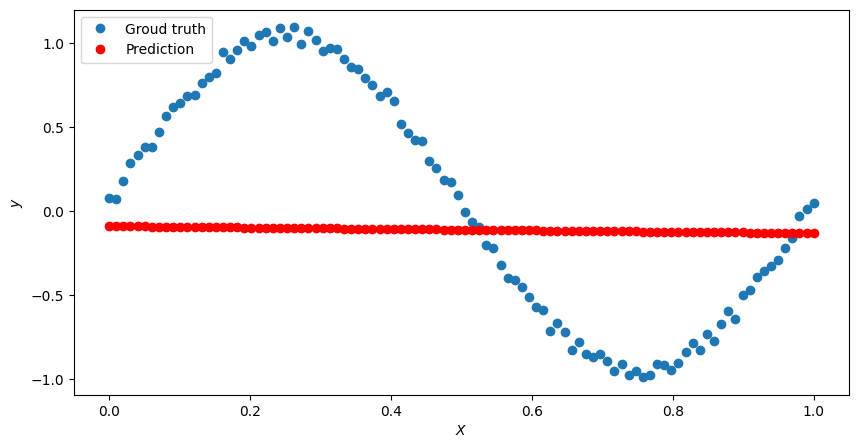

In [10]:
def predict(net, X, y):
    y_pred = net.forward(X)

    plt.figure(figsize=(10, 5))
    plt.plot(X.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(X.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$X$')
    plt.ylabel('$y$')

predict(sine_net, X, y)

In [11]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss(reduction='sum')

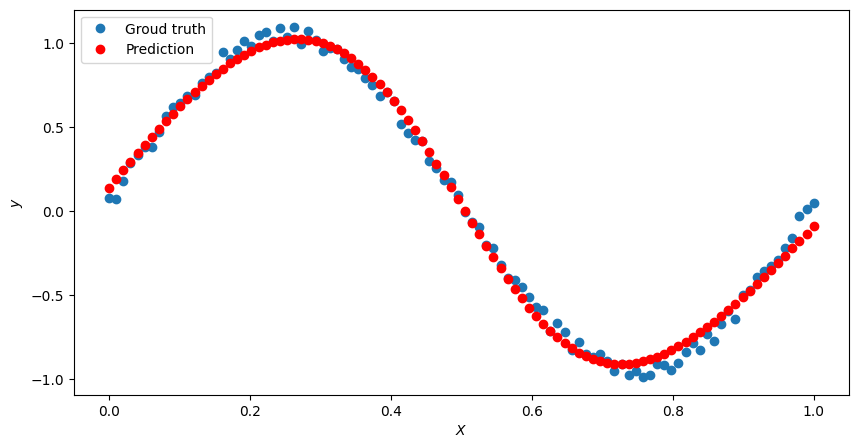

In [12]:
for epoch_index in range(1000):
    optimizer.zero_grad()

    y_pred = sine_net.forward(X)
    loss_val = criterion.forward(y_pred, y)

    loss_val.backward()

    optimizer.step()

predict(sine_net, X, y)

3.3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [13]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [14]:
model = nn.Sequential(
  nn.Linear(1, 42),
  nn.ReLU(),
  nn.Linear(42, 1)
)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='sum')

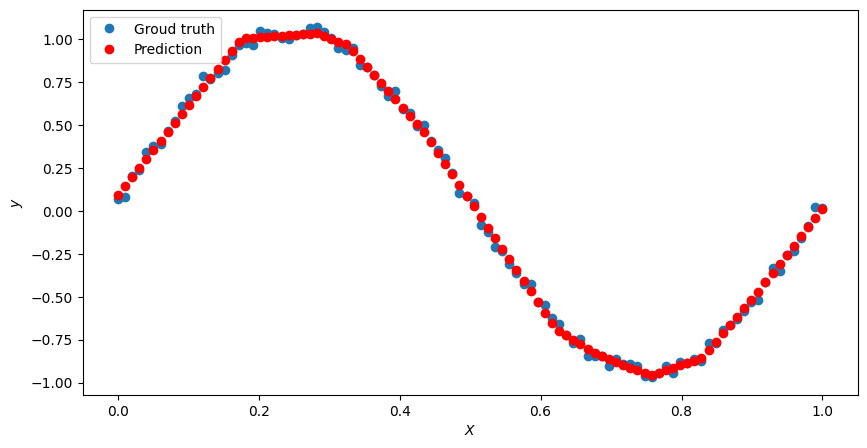

In [16]:
for epoch_index in range(10000):

    y_pred = model(X)
    loss_val = criterion(y_pred, y)

    optimizer.zero_grad()
    loss_val.backward()

    optimizer.step()

predict(model, X, y)

## 3.4. Datasets and dataloaders

3.4.1 Создать датасет, поставляющий данные из задачи 3.1.2. 

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.3.1 (или 3.3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [17]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [18]:
class SinDataset(Dataset):
  def __init__(self, x_data, y_data):
    super(Dataset, self).__init__()
    self.x_data = x_data
    self.y_data = y_data
    self.len = len(self.x_data)

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.x_data[idx], self.y_data[idx]

In [19]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sine_net = SineNet(50)

In [20]:
model = nn.Sequential(
  nn.Linear(1, 42),
  nn.ReLU(),
  nn.Linear(42, 1)
)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [21]:
data = SinDataset(X, y)
data_loader = DataLoader(data, batch_size=10, shuffle=True)

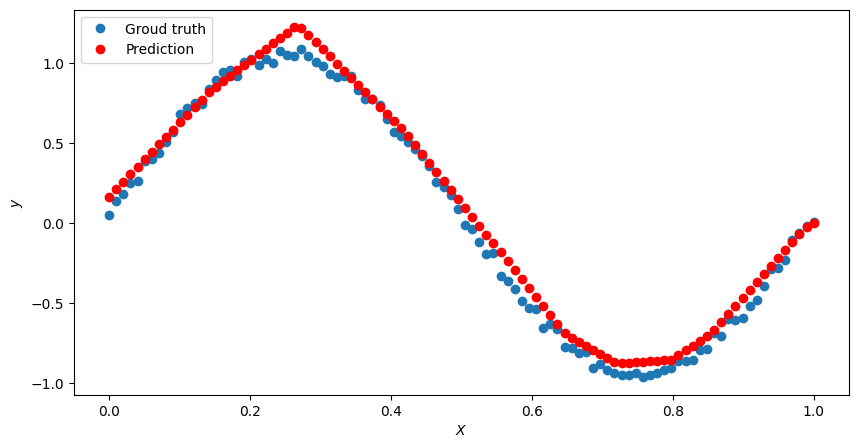

In [22]:
for i in range(1000):
    for batch, dt in enumerate(data_loader):
        X_mini, y_mini = dt
        pred = model(X_mini)
        l = criterion(pred, y_mini)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

predict(model, X, y)

3.4.2 Предсказание цен алмазов

3.4.2.1 Создайте датасет на основе файла diamonds.csv. 

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров



In [23]:
df = pd.read_csv('/content/drive/MyDrive/Uni/diamonds.csv', index_col=0)
df

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [24]:
df = df[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']]
df

,carat,depth,table,price,x,y,z
1,0.23,61.5,55.0,326,3.95,3.98,2.43
2,0.21,59.8,61.0,326,3.89,3.84,2.31
3,0.23,56.9,65.0,327,4.05,4.07,2.31
4,0.29,62.4,58.0,334,4.20,4.23,2.63
5,0.31,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...
53936,0.72,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,61.0,58.0,2757,6.15,6.12,3.74


In [25]:
df['target'] = np.log(df['price'])

<ipython-input-25-aea09f144796>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = np.log(df['price'])


In [26]:
class DiamondsDataset(Dataset):
    def __init__(self, data):
        super(Dataset, self).__init__()
        self.X = torch.tensor(data.drop(columns=['price', 'target']).values, dtype=torch.float32)
        self.y = torch.tensor(data['target'].values.reshape(-1, 1), dtype=torch.float32)
        self.len_x = len(self.X)

    def __len__(self):
        return self.len_x

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

3.4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.



In [27]:
data = DiamondsDataset(df)
data_train, data_test = random_split(data, (int(0.8*len(data)), len(data)-int(0.8*len(data))),
                                     generator=torch.Generator().manual_seed(42))

3.4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`). 


In [28]:
train_loader = DataLoader(data_train, batch_size=256, shuffle=True)
test_loader = DataLoader(data_test, batch_size=256, shuffle=True)

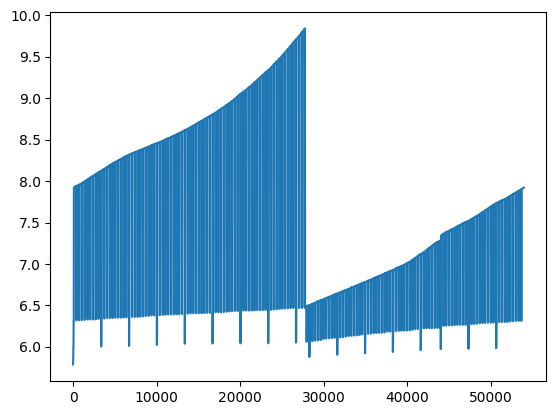

In [29]:
plt.plot(df['target'])

In [30]:
model = model = nn.Sequential(
    nn.Linear(6, 64),
    nn.Tanh(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
summary(model, (6,), batch_size=256)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [256, 64]             448
              Tanh-2                  [256, 64]               0
            Linear-3                  [256, 16]           1,040
              ReLU-4                  [256, 16]               0
            Linear-5                   [256, 1]              17
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.31
Params size (MB): 0.01
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [31]:
history = []

for i in range(200):
    history_by_epoch = []
    for batch, dt in enumerate(train_loader):
        X_mini, y_mini = dt
        pred = model(X_mini)

        loss_func = loss(pred, y_mini)
        history_by_epoch.append(loss_func.item())
        
        optimizer.zero_grad()
        loss_func.backward()

        optimizer.step()
    history.append(np.mean(history_by_epoch))


3.4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке. 


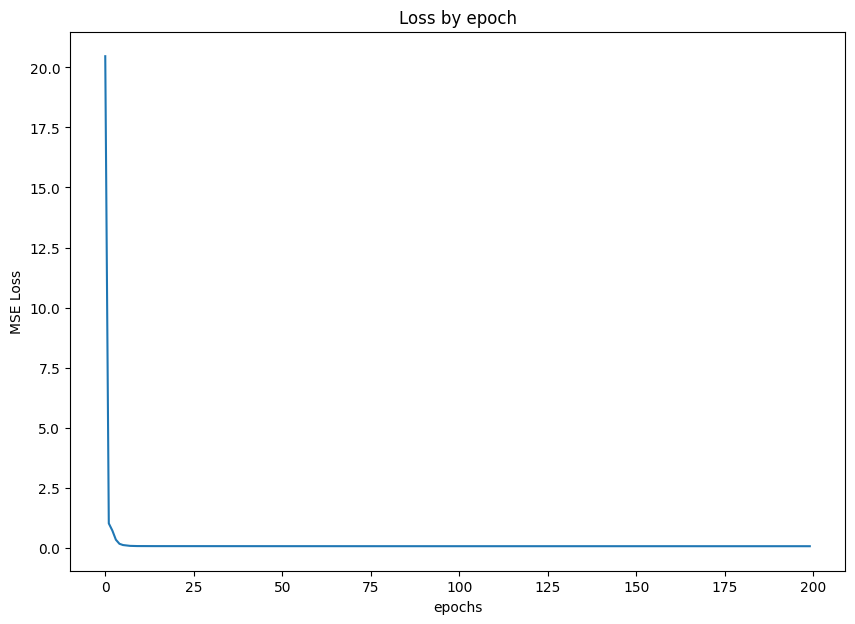

In [32]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by epoch')
plt.ylabel('MSE Loss')
plt.xlabel('epochs')
plt.show()

In [33]:
mean_loss_test = []
for batch, dt in enumerate(test_loader):
    X_mini, y_mini = dt
    pred = model(X_mini)
    l = loss(pred, y_mini)
    mean_loss_test.append(l.item())
np.mean(mean_loss_test)

0.06231648292998935

In [34]:
X = df.drop(columns=['target', 'price'])
X.shape

(53940, 6)

In [35]:
X = torch.tensor(X.values, dtype=torch.float32)

In [36]:
pred = model(X)

In [37]:
pred_dif = pd.DataFrame(np.exp(pred.detach().numpy()), columns=['pred'], index=df.index)
pred_dif['price'] = df['price'].copy()
pred_dif['dif'] = pred_dif['price'] - pred_dif['pred']
pred_dif

,pred,price,dif
1,552.212219,326,-226.212219
2,490.037476,326,-164.037476
3,467.623322,327,-140.623322
4,623.327148,334,-289.327148
5,663.658020,335,-328.658020
...,...,...,...
53936,2692.621582,2757,64.378418
53937,2594.122070,2757,162.877930
53938,2304.300293,2757,452.699707
53939,3705.032715,2757,-948.032715


3.4.3 Модифицируйте метод `__init__` датасета из 3.4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [38]:
class DiamondsDataset(Dataset):
  def __init__(self, data, transform):
    # ....
    super(Dataset, self).__init__()
    self.transform = transform
    self.data = data
    self.X = np.delete(self.data, 6, axis=1)
    self.y = self.data[:, [6]]
    self.len_x = len(self.X)
    # ....

  def __len__(self):
    return self.len_x

  def __getitem__(self, idx):
    # ...
    sample = self.X[idx], self.y[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample
    # ....

In [39]:
class DropColsTransform:
  def __init__(self, drop1):
      self.drop1 = drop1

  def __call__(self, sample):
      X, y = sample
      X = np.delete(X, self.drop1)
      return X.astype(np.float32), y.astype(np.float32)

In [40]:
class ToTensorTransform:
  def __call__(self, sample):
    X, y = sample
    return torch.from_numpy(X), torch.from_numpy(y)

In [41]:
data = np.loadtxt('/content/drive/MyDrive/Uni/diamonds.csv',delimiter=',', skiprows=1, dtype='S', encoding='utf-8',
                  usecols=range(1, 11))
data.shape

(53940, 10)

In [42]:
data

array([[b'0.23', b'"Ideal"', b'"E"', ..., b'3.95', b'3.98', b'2.43'],
       [b'0.21', b'"Premium"', b'"E"', ..., b'3.89', b'3.84', b'2.31'],
       [b'0.23', b'"Good"', b'"E"', ..., b'4.05', b'4.07', b'2.31'],
       ...,
       [b'0.7', b'"Very Good"', b'"D"', ..., b'5.66', b'5.68', b'3.56'],
       [b'0.86', b'"Premium"', b'"H"', ..., b'6.15', b'6.12', b'3.74'],
       [b'0.75', b'"Ideal"', b'"D"', ..., b'5.83', b'5.87', b'3.64']],
      dtype='|S11')

In [43]:
drop = DropColsTransform(drop1=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(data, transforms.Compose([drop, to_tensor]))


In [44]:
x0, y0 = dataset[0]
print(x0, y0)

tensor([ 0.2300, 61.5000, 55.0000,  3.9500,  3.9800,  2.4300]) tensor([326.])
